# Описание проекта

Проект основан на участии в локальном соревновании REU ML SCHOOL на платформе Kaggle: https://www.kaggle.com/competitions/car-price-prediction-ru/overview

Цель проекта - предсказание цен автомобиля.

Описание датасетов:

*   df_train - тренировочный датасет;
*   df_test - тестовый датасет;
*   submission - образец файла отправки в правильном формате.

Метрика: RLMSE





# Установка и импортирование необходимых бибилиотек

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.3 MB/s eta 0:00:00


In [2]:
from pandas import *
from numpy import *
import matplotlib.pyplot as plt
from google.colab import *
import re


from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# Загрузка датасетов

In [3]:
drive.mount('/content/drive')
path1 = '/content/drive/My Drive/test.csv'
path2 = '/content/drive/My Drive/train.csv'
path3 = '/content/drive/My Drive/sample_submission.csv'
df_test = read_csv(path1)
df_train = read_csv(path2)
submission = read_csv(path3)

Mounted at /content/drive


In [4]:
df_train.sample(5)

,car_id,car_mark,year,mileage,engine,drive,body,color,transmission,brand,price
50567,34976,LADA (ВАЗ) Vesta I,2020,118 000 км,1.6 л / 106 л.с. / Бензин,передний,седан,синий,механика,LADA (ВАЗ),745000
37733,11315,Chevrolet Cruze I,2011,143 000 км,1.6 л / 109 л.с. / Бензин,передний,седан,бежевый,автомат,Chevrolet,550000
15721,58618,Rolls-Royce Ghost Extended II,2021,29 км,6.8 л / 571 л.с. / Бензин,полный,седан,чёрный,автомат,Rolls-Royce,43800000
9738,38462,Lexus NX 200 I Рестайлинг,2020,22 000 км,2.0 л / 150 л.с. / Бензин,полный,внедорожник 5 дв.,белый,вариатор,Lexus,4800000
39798,6896,BMW X7 30d I (G07),2022,Новый,3.0 л / 249 л.с. / Дизель,полный,внедорожник 5 дв.,xDrive30d M Sport Pro,автомат,BMW,14770000


In [5]:
df_test.sample(5)

,car_id,car_mark,year,mileage,engine,drive,body,color,transmission,brand
15494,4159,BMW X5 40d IV (G05),2021,30 000 км,3.0 л / 340 л.с. / Дизель,полный,внедорожник 5 дв.,синий,автомат,BMW
1776,25056,Hyundai i20 I,2010,122 546 км,1.4 л / 100 л.с. / Бензин,передний,хэтчбек 5 дв.,серебристый,автомат,Hyundai
1531,15370,Datsun on-DO I Рестайлинг,2020,4 835 км,1.6 л / 87 л.с. / Бензин,передний,седан,коричневый,механика,Datsun
16781,43780,"Mercedes-Benz E-Класс 200 V (W213, S213, C238)",2019,95 000 км,2.0 л / 197 л.с. / Бензин,полный,седан,чёрный,автомат,Mercedes-Benz
16004,36070,Land Rover Range Rover Evoque II,2022,Новый,2.0 л / 163 л.с. / Дизель,полный,внедорожник 5 дв.,Standard,автомат,Land Rover


In [6]:
submission.sample(5)

,car_id,predicted_price
1174,29924,0
10591,39142,0
1711,29258,0
13115,72623,0
12726,63490,0


# Анализ тренировочного датасета

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57066 entries, 0 to 57065
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   car_id        57066 non-null  int64 
 1   car_mark      57066 non-null  object
 2   year          57066 non-null  int64 
 3   mileage       57066 non-null  object
 4   engine        57066 non-null  object
 5   drive         57066 non-null  object
 6   body          57066 non-null  object
 7   color         57066 non-null  object
 8   transmission  57066 non-null  object
 9   brand         57066 non-null  object
 10  price         57066 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 4.8+ MB


Колонки датасета:

*   car_id - id машины;
*   car_mark - модель машины;
*   year - год выпуска машины;
*   mileage - пробег;
*   engine - характеристики двигателя;
*   drive - привод;
*   body - кузов;
*   color - цвет;
*   transmission - коробка передач;
*   brand - марка машины;
*   price - цена машины.







In [9]:
options.display.float_format = '{:.2f}'.format

In [10]:
df_train.describe()

,car_id,year,price
count,57066.00,57066.00,57066.00
mean,38013.78,2014.35,2722473.73
std,21987.81,8.08,4192430.38
min,1.00,1923.00,20000.00
25%,18958.25,2011.00,735000.00
50%,37990.50,2016.00,1580000.00
75%,57014.75,2021.00,2986975.00
max,76086.00,2022.00,111000000.00


In [11]:
df_train.isnull().sum()

car_id          0
car_mark        0
year            0
mileage         0
engine          0
drive           0
body            0
color           0
transmission    0
brand           0
price           0
dtype: int64

# Предобработка тренировочного датасета

In [12]:
df_train.sample(5)

,car_id,car_mark,year,mileage,engine,drive,body,color,transmission,brand,price
27440,65661,Toyota Yaris Multimode II,2008,148 451 км,1.3 л / 87 л.с. / Бензин,передний,хэтчбек 5 дв.,чёрный,робот,Toyota,460000
22786,29352,Infiniti G G35 IV,2008,150 000 км,3.5 л / 309 л.с. / Бензин,задний,седан,синий,автомат,Infiniti,650000
16854,2075,Audi A4 V (B9),2016,80 000 км,1.4 л / 150 л.с. / Бензин,передний,седан,синий,робот,Audi,1900000
18973,23982,Honda Accord VIII Рестайлинг,2011,166 000 км,2.2 л / 150 л.с. / Дизель,передний,универсал 5 дв.,серый,автомат,Honda,1300000
43330,32269,Kia K5 III,2022,Новый,2.5 л / 194 л.с. / Бензин,передний,седан,Luxe (2020-2021),автомат,Kia,3466740


Первым делом разберемся с коробкой передач. Посмотрим сколько всего уникальных значений

In [ ]:
df_train['transmission'].value_counts()

автомат            29899
механика           12972
робот               7661
вариатор            6190
Заряд на 496 км       43
                   ...  
Заряд на 484 км        1
Заряд на 550 км        1
Заряд на 562 км        1
Заряд на 280 км        1
Заряд на 497 км        1
Name: transmission, Length: 66, dtype: int64

Можно заметить, что преобладает 4 основных вида коробок передач:

1. автомат;
2. механика;
3. робот;
4. вариатор.

Все остальное связано с электрокарами. Обычно, в подобных авто тип трансмиссии - редуктор. Заменим все значения, начинющиеся с "Заряд" на "Редуктор"

In [13]:
df_train.loc[df_train['transmission'].str.startswith('Заряд') == True, 'transmission'] = 'редуктор'

In [14]:
df_train['transmission'].value_counts()

автомат     29899
механика    12972
робот        7661
вариатор     6190
редуктор      344
Name: transmission, dtype: int64

In [15]:
df_train.sample(5)

,car_id,car_mark,year,mileage,engine,drive,body,color,transmission,brand,price
19516,7916,BYD Han,2020,470 км,494 л.с. / 363 кВт / Электро,полный,седан,красный,редуктор,BYD,4200000
26521,58015,Renault Logan II,2016,80 800 км,1.6 л / 102 л.с. / Бензин,передний,седан,серебристый,механика,Renault,685000
25128,21265,Geely Atlas Pro,2021,Новый,1.5 л / 177 л.с. / Бензин,полный,внедорожник 5 дв.,Flagship,робот,Geely,2448990
40829,12117,Chevrolet Orlando I,2013,196 000 км,2.0 л / 163 л.с. / Дизель,передний,компактвэн,серый,автомат,Chevrolet,930000
46087,890,Audi Q5 I (8R),2009,153 999 км,2.0 л / 211 л.с. / Бензин,полный,внедорожник 5 дв.,чёрный,робот,Audi,1030000


Посмотрим на пробег

In [16]:
df_train['mileage'].value_counts()

Новый         13339
200 000 км      466
150 000 км      301
170 000 км      293
130 000 км      290
              ...  
4 626 км          1
102 902 км        1
84 800 км         1
148 400 км        1
47 224 км         1
Name: mileage, Length: 12717, dtype: int64

Очевидно, что у новых авто пробег равен 0. Заменим пробег всех новых авто на 0, а также удалим приставку "км"

In [17]:
df_train.loc[df_train['mileage'] == 'Новый', 'mileage'] = 0
df_train['mileage'] = df_train['mileage'].str.replace("\xa0", "").str.replace('км', '').fillna(0).astype(int)
df_train.sample(5)

,car_id,car_mark,year,mileage,engine,drive,body,color,transmission,brand,price
787,74975,ГАЗ 69,1964,5000,2.1 л / 55 л.с. / Бензин,полный,внедорожник 3 дв.,зелёный,механика,ГАЗ,450000
49301,65333,Toyota RAV4 V (XA50),2022,0,2.0 л / 149 л.с. / Бензин,полный,внедорожник 5 дв.,Престиж Safety,вариатор,Toyota,5600000
629,38821,Lexus NX 200 I Рестайлинг,2018,59000,2.0 л / 150 л.с. / Бензин,полный,внедорожник 5 дв.,чёрный,вариатор,Lexus,3550000
3605,23227,Haval F7x I Рестайлинг,2022,0,1.5 л / 150 л.с. / Бензин,полный,внедорожник 5 дв.,Premium,робот,Haval,2696000
27527,66057,Toyota Venza II,2021,63,2.5 л / 222 л.с. / Гибрид,полный,внедорожник 5 дв.,серый,вариатор,Toyota,6095000


Далее разберемся с характристиками двигателя. Для начала, создадим функцию, меняющую местами л.с. и кВт у электроавтомобилей

In [18]:
def swap_power(s):

    ''' Функция, меняющую местами л.с. и кВт у электроавтомобилей'''
    
    pattern = r'(\d+)\s*л\.с\..*?(\d+)\s*кВт.*?(\w+)'
    match = re.search(pattern, s)
    if match and match.group(3) == 'Электро':
        return f"{match.group(2)} кВт / {match.group(1)} л.с. / {match.group(3)}"
    else:
        return s

df_train['engine'] = df_train['engine'].apply(swap_power)

In [19]:
df_train.loc[((df_train['brand'] == 'Tesla'))].sample(5)

,car_id,car_mark,year,mileage,engine,drive,body,color,transmission,brand,price
15583,65031,Tesla Model S P85 I,2014,83200,310 кВт / 422 л.с. / Электро,задний,лифтбек,красный,редуктор,Tesla,3900000
3191,65081,Tesla Model Y Long Range I,2020,163,254 кВт / 345 л.с. / Электро,полный,внедорожник 5 дв.,серый,редуктор,Tesla,4300000
30904,64920,Tesla Model S P85 I,2013,116000,310 кВт / 422 л.с. / Электро,задний,лифтбек,чёрный,редуктор,Tesla,2450000
39647,64932,Tesla Model X Long Range I Рестайлинг,2022,0,500 кВт / 670 л.с. / Электро,полный,внедорожник 5 дв.,Model X,редуктор,Tesla,12659000
2430,64935,Tesla Model 3 Performance I,2018,62000,340 кВт / 462 л.с. / Электро,полный,седан,серебристый,редуктор,Tesla,3850000


Создадим колонку "engine_info" куда передадим список из характристик двигателя без всяких приставок

In [20]:
def engine(engine_info_str):
    pattern = r"([\d\.]+)\s*л\.?\s*\/\s*([\d\.]+)\s*л\.?с\.?\s*\/\s*([\w\s]+)"
    match = re.match(pattern, engine_info_str)
    if match:
        return [match.group(1), match.group(2), match.group(3)]
    else:
        pattern = r"([\d\.]+)\s*кВт\s*\/\s*([\d\.]+)\s*л\.?с\.?\s*\/\s*([\w\s]+)"
        match = re.match(pattern, engine_info_str)
        if match:
            return [match.group(1), match.group(2), match.group(3)]
        else:
            return []

In [21]:
df_train['engine_info'] = df_train['engine'].apply(engine)

In [22]:
df_train.sample(5)

,car_id,car_mark,year,mileage,engine,drive,body,color,transmission,brand,price,engine_info
2949,65425,Toyota Land Cruiser 200 Series Рестайлинг 2,2016,198600,4.5 л / 249 л.с. / Дизель,полный,внедорожник 5 дв.,чёрный,автомат,Toyota,4789000,"[4.5, 249, Дизель]"
10511,72709,Volvo XC60 I,2010,169000,2.0 л / 203 л.с. / Бензин,передний,внедорожник 5 дв.,золотистый,робот,Volvo,950000,"[2.0, 203, Бензин]"
19688,43966,"Mercedes-Benz E-Класс 350 d V (W213, S213, C23...",2021,12700,2.9 л / 249 л.с. / Дизель,полный,седан,чёрный,автомат,Mercedes-Benz,8500000,"[2.9, 249, Дизель]"
54119,55744,Renault Sandero II Рестайлинг,2019,11391,1.6 л / 113 л.с. / Бензин,передний,хэтчбек 5 дв.,серый,механика,Renault,900000,"[1.6, 113, Бензин]"
11954,28286,Hyundai Solaris II Рестайлинг,2022,0,1.6 л / 123 л.с. / Бензин,передний,седан,Elegance,автомат,Hyundai,1593480,"[1.6, 123, Бензин]"


Разобъем характеристики авто на 3 колонки

In [23]:
df_train['engine_volume'] = df_train['engine_info'].apply(lambda x: x[0])
df_train['engine_power'] = df_train['engine_info'].apply(lambda x: x[1])
df_train['fuel_type'] = df_train['engine_info'].apply(lambda x: x[2])
df_train.sample(5)

,car_id,car_mark,year,mileage,engine,drive,body,color,transmission,brand,price,engine_info,engine_volume,engine_power,fuel_type
9914,41594,"Mercedes-Benz E-Класс 200 d V (W213, S213, C238)",2018,189000,2.0 л / 150 л.с. / Дизель,задний,седан,чёрный,автомат,Mercedes-Benz,2200000,"[2.0, 150, Дизель]",2.0,150,Дизель
2353,20430,Ford Focus II Рестайлинг,2009,164000,1.8 л / 116 л.с. / Дизель,передний,седан,синий,механика,Ford,350000,"[1.8, 116, Дизель]",1.8,116,Дизель
2798,7810,BMW 3 серии 325xi V (E90/E91/E92/E93),2008,170000,2.5 л / 218 л.с. / Бензин,полный,купе,чёрный,автомат,BMW,1199000,"[2.5, 218, Бензин]",2.5,218,Бензин
41946,44457,"Mercedes-Benz E-Класс 200 V (W213, S213, C238)...",2022,0,2.0 л / 197 л.с. / Бензин,полный,седан,E 200 4MATIC Sport,автомат,Mercedes-Benz,7463200,"[2.0, 197, Бензин]",2.0,197,Бензин
51659,21336,Geely Atlas I,2019,54000,1.8 л / 184 л.с. / Бензин,полный,внедорожник 5 дв.,коричневый,автомат,Geely,2000000,"[1.8, 184, Бензин]",1.8,184,Бензин


У электроавтомобилей нет понятия литров, поэтому создадим отдельную колонку "engine_charge" где будет заряд двигателя электромобилей

In [24]:
df_train['engine_charge'] = df_train.apply(lambda x: x['engine_volume'] if x['fuel_type'] == 'Электро' else 0, axis=1)

In [25]:
df_train.loc[((df_train['brand'] == 'Tesla'))].sample(5)

,car_id,car_mark,year,mileage,engine,drive,body,color,transmission,brand,price,engine_info,engine_volume,engine_power,fuel_type,engine_charge
16123,64977,Tesla Model S 75 I Рестайлинг,2016,81000,285 кВт / 382 л.с. / Электро,задний,лифтбек,белый,редуктор,Tesla,3700000,"[285, 382, Электро]",285,382,Электро,285
22007,65046,Tesla Model S P85 I,2013,190000,310 кВт / 422 л.с. / Электро,задний,лифтбек,красный,редуктор,Tesla,2865000,"[310, 422, Электро]",310,422,Электро,310
8238,65077,Tesla Model Y Long Range I,2021,13000,254 кВт / 345 л.с. / Электро,полный,внедорожник 5 дв.,красный,редуктор,Tesla,6490000,"[254, 345, Электро]",254,345,Электро,254
3471,64955,Tesla Model S Plaid I Рестайлинг 2,2021,6640,761 кВт / 1020 л.с. / Электро,полный,лифтбек,чёрный,редуктор,Tesla,12500000,"[761, 1020, Электро]",761,1020,Электро,761
52430,65074,Tesla Model S 75D I Рестайлинг,2017,41100,245 кВт / 333 л.с. / Электро,полный,лифтбек,чёрный,редуктор,Tesla,3900000,"[245, 333, Электро]",245,333,Электро,245


Заменим кол-во литров двигателя электрокаров на 0

In [26]:
df_train.loc[df_train['fuel_type'] == 'Электро', 'engine_volume'] = 0
df_train = df_train.drop(["engine", "engine_info"], axis=1)

In [29]:
df_train.sample(5)

,car_id,car_mark,year,mileage,drive,body,color,transmission,brand,price,engine_volume,engine_power,fuel_type,engine_charge
24137,70913,Volkswagen Polo VI,2020,39500,передний,лифтбек,серый,робот,Volkswagen,1390000,1.4,125,Бензин,0
13998,2182,Audi e-tron 50 I,2020,10500,полный,внедорожник 5 дв.,чёрный,редуктор,Audi,6450000,0,313,Электро,230
21271,2482,Audi A6 IV (C7) Рестайлинг,2016,134500,передний,седан,синий,робот,Audi,1700000,1.8,190,Бензин,0
47136,14708,Daewoo Matiz II Рестайлинг,2007,61320,передний,хэтчбек 5 дв.,зелёный,механика,Daewoo,150000,0.8,52,Бензин,0
50625,61118,Skoda Felicia I,1996,238000,передний,хэтчбек 5 дв.,белый,механика,Skoda,75000,1.6,75,Бензин,0


In [30]:
df_train.loc[((df_train['brand'] == 'Tesla'))].sample(5)

,car_id,car_mark,year,mileage,drive,body,color,transmission,brand,price,engine_volume,engine_power,fuel_type,engine_charge
21092,65061,Tesla Model 3 Standart Plus I,2019,18653,задний,седан,серый,редуктор,Tesla,4500000,0,258,Электро,190
55601,65042,Tesla Model X 100D I,2018,46750,полный,внедорожник 5 дв.,белый,редуктор,Tesla,7800000,0,423,Электро,311
43158,65026,Tesla Model 3 Performance I,2020,820,полный,седан,серый,редуктор,Tesla,4300000,0,462,Электро,340
11351,64978,Tesla Model 3 Performance I,2021,16250,полный,седан,чёрный,редуктор,Tesla,5600000,0,462,Электро,340
52815,64903,Tesla Model S 60 I,2015,50000,задний,лифтбек,синий,редуктор,Tesla,2999000,0,302,Электро,222


Посмотрим на цвет

In [ ]:
df_train['color'].value_counts().to_frame()

,color
чёрный,11440
белый,8622
серый,6488
синий,4526
серебристый,3704
...,...
GTS Coupé,1
R-Dynamic Black,1
M440i xDrive BMW M 50 Years Special Edition,1
4S,1


Создадим список самых популярных цветов. Остальные цвета заменим на "другой"

In [31]:
color_list = ['чёрный','белый','серый','синий','серебристый','красный','коричневый','зелёный','бежевый','Flagship','голубой','Elite',
 'жёлтый','Prestige','Active','Style','Comfort','Intense+','Luxe','фиолетовый','пурпурный','золотистый', 'оранжевый']
df_train['color'] = df_train['color'].apply(lambda x: x if x in color_list else 'другой')
df_train['color'].value_counts()

чёрный         11440
другой          9386
белый           8622
серый           6488
синий           4526
серебристый     3704
красный         2365
коричневый      1924
зелёный         1496
бежевый          799
Flagship         681
голубой          551
Elite            531
жёлтый           521
Prestige         517
Active           497
Style            491
Comfort          446
Intense+         434
Luxe             365
фиолетовый       345
пурпурный        333
золотистый       307
оранжевый        297
Name: color, dtype: int64

# Предобработка тестового датасета

In [32]:
df_test.loc[df_test['transmission'].str.startswith('Заряд') == True, 'transmission'] = 'редуктор'
df_test.loc[df_test['mileage'] == 'Новый', 'mileage'] = 0
df_test['mileage'] = df_test['mileage'].str.replace("\xa0", "").str.replace('км', '').fillna(0).astype(int)
df_test['engine'] = df_test['engine'].apply(swap_power)
df_test['engine_info'] = df_test['engine'].apply(engine)
df_test['engine_volume'] = df_test['engine_info'].apply(lambda x: x[0])
df_test['engine_power'] = df_test['engine_info'].apply(lambda x: x[1])
df_test['fuel_type'] = df_test['engine_info'].apply(lambda x: x[2])
df_test['engine_charge'] = df_test.apply(lambda x: x['engine_volume'] if x['fuel_type'] == 'Электро' else 0, axis=1)
df_test.loc[df_test['fuel_type'] == 'Электро', 'engine_volume'] = 0
df_test = df_test.drop(["engine", "engine_info"], axis=1)
df_test['color'] = df_test['color'].apply(lambda x: x if x in color_list else 'другой')

# Кодировка признаков

Закодируем признаки с помощью LabelEncoder()

In [33]:
df_combined = concat([df_train, df_test], axis=0)

# Создание экземпляра LabelEncoder
label_encoder = LabelEncoder()

# Кодирование категориальных признаков в объединенном датасете
df_combined['car_mark'] = label_encoder.fit_transform(df_combined['car_mark'])
df_combined['drive'] = label_encoder.fit_transform(df_combined['drive'])
df_combined['body'] = label_encoder.fit_transform(df_combined['body'])
df_combined['color'] = label_encoder.fit_transform(df_combined['color'])
df_combined['transmission'] = label_encoder.fit_transform(df_combined['transmission'])
df_combined['brand'] = label_encoder.fit_transform(df_combined['brand'])
df_combined['fuel_type'] = label_encoder.fit_transform(df_combined['fuel_type'])

# Разделение объединенного датасета на обучающий и тестовый датасеты
df_train_encoded = df_combined[:len(df_train)]
df_test_encoded = df_combined[len(df_train):]

In [34]:
df_train_encoded['car_id'] = 0

<ipython-input-34-7c2305911ca0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_encoded['car_id'] = 0


In [35]:
df_train_encoded.sample(5)

,car_id,car_mark,year,mileage,drive,body,color,transmission,brand,price,engine_volume,engine_power,fuel_type,engine_charge
52216,0,1108,2008,131000,1,26,23,2,37,415000.00,1.4,80,0,0
56399,0,2079,2021,0,1,1,0,0,76,3267000.00,2.0,150,0,0
4413,0,372,2012,107000,2,5,23,0,9,1980000.00,4.4,407,0,0
16365,0,1454,2012,135000,1,26,19,0,54,820000.00,1.6,130,0,0
44387,0,2545,1997,540000,2,1,20,2,80,220000.00,3.0,177,0,0


# ML

В качестве модели машинного обучения мною была выбрана модель CatBoost. Для начала разделим данные

In [36]:
X = df_train_encoded.drop(columns = ['price'],axis = 1)
y = df_train_encoded['price']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 1, test_size=0.3)

Подберем параметры для модели с помощью GridSearchCV()

In [41]:
model = CatBoostRegressor(verbose=0, random_seed = 42)

param_grid = {'learning_rate': [0.1, 0.01],
              'depth': [8, 12],
              'iterations': [1000,1200]}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid)

# Обучение модели
grid_search.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = grid_search.predict(X_test)

# Оценка качества модели
def RLMSE(y_test, y_pred):
    log_true = log1p(y_test)
    log_pred = log1p(y_pred)
    return sqrt(mean((log_true - log_pred)**2))

print(RLMSE(y_test, y_pred))
print("Best parameters: ", grid_search.best_params_)

0.26625769660153936
Best parameters:  {'depth': 8, 'iterations': 1200, 'learning_rate': 0.1}


<ipython-input-41-b73a81762791>:18: RuntimeWarning: invalid value encountered in log1p
  log_pred = log1p(y_pred)


In [43]:
final_model = CatBoostRegressor(verbose=0, random_seed=42, depth = 8, learning_rate = 0.1, iterations = 1200)

# Обучение модели
final_model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = final_model.predict(X_test)

# Оценка качества модели
def RLMSE(y_test, y_pred):
    log_true = log1p(y_test)
    log_pred = log1p(y_pred)
    return sqrt(mean((log_true - log_pred)**2))

print("RLMSE_score: ", RLMSE(y_test, y_pred).round(3))
final_model.save_model('car_price_model.cbm')

RLMSE_score:  0.266


<ipython-input-43-af019597b64c>:12: RuntimeWarning: invalid value encountered in log1p
  log_pred = log1p(y_pred)


# Предсказание цен

In [44]:
model_1 = CatBoostRegressor()
model_1.load_model('car_price_model.cbm')

In [46]:
df_test_encoded['price']= model_1.predict(df_test_encoded).round(0)

<ipython-input-46-e0fd374c7256>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_encoded['price']= model_1.predict(df_test_encoded).round(0)


In [47]:
df_test_encoded.sample(5)

,car_id,car_mark,year,mileage,drive,body,color,transmission,brand,price,engine_volume,engine_power,fuel_type,engine_charge
12141,36359,1808,2012,94466,2,0,20,2,66,1918811.00,2.2,190,3,0
17214,57907,2918,2022,0,2,1,11,2,94,1727853.00,1.6,114,0,0
553,40416,2069,2022,0,1,15,11,0,76,3680184.00,2.5,194,0,0
10060,11057,760,2001,137400,2,1,13,0,18,1254734.00,6.0,304,0,0
9792,49476,2658,2017,34500,2,1,9,1,83,1683932.00,2.0,144,0,0


In [48]:
submission.sample(5)

,car_id,predicted_price
10267,46455,0
4969,3504,0
2731,65391,0
16162,11537,0
16898,69782,0


In [49]:
predicted_price_df = submission.merge(df_test_encoded[['car_id', 'price']], on='car_id', how='left').drop(columns = ['predicted_price'],axis = 1)
predicted_price_df.rename(columns={'price': 'predicted_price'}, inplace=True)
predicted_price_df.sample(5)

,car_id,predicted_price
15916,33322,982455.00
14587,4011,9935170.00
7504,40986,14285908.00
7275,53065,323538.00
6015,13407,767629.00


In [50]:
predicted_price_df.to_csv('/content/drive/My Drive/pred_price.csv', index=False)

# Итог

Прогнозирование цен на автомобили с помощью моделей машинного обучения является важным инструментом в автомобильной индустрии. Они позволяют как продавцам, так и покупателям получать более точные и надежные оценки стоимости автомобилей на основе доступных данных.

Заключение такого прогнозирования может быть полезным для различных участников рынка автомобилей. Продавцы могут определить адекватные цены для своих автомобилей на основе анализа и предсказания рыночных условий и конкуренции. Покупатели могут использовать прогнозы цен для принятия информированных решений при покупке автомобиля, чтобы получить наилучшую цену и избежать переплаты.

Однако, стоит отметить, что прогнозирование цен на автомобили является сложной задачей из-за большого количества факторов, влияющих на ценообразование, включая изменения рыночных условий, модельный цикл, спрос и предложение, состояние автомобиля и другие. Точность прогнозов может зависеть от качества и доступности данных, а также от правильного выбора и настройки модели.

Что же касается личных исследований, CatBoost неплохо решает данную задачу. Метрика после обучения модели составила 0.266. На Kaggle "Private score" = 0.38, "Public score" = 0.32. (5 место из 18). 

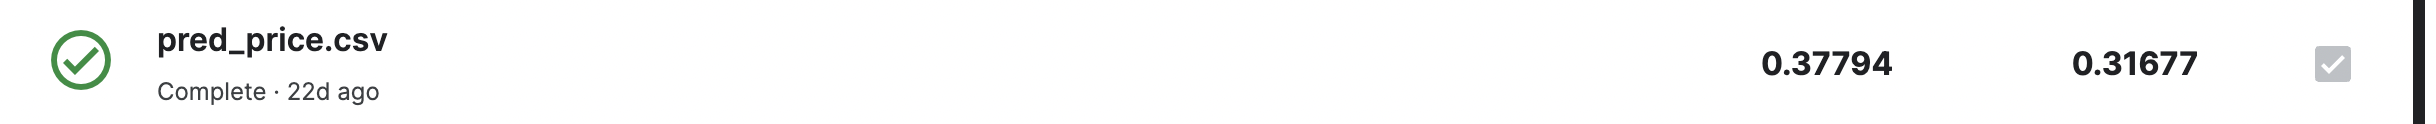

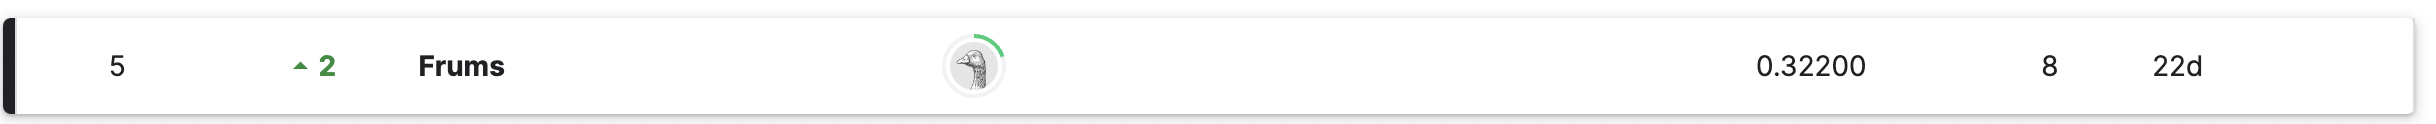